In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-potability/water_potability.csv


In [2]:
data=pd.read_csv("/kaggle/input/water-potability/water_potability.csv")

In [3]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
data['Potability'].unique()

array([0, 1])

## DATA PRE-PROCESSING

#### Finding Missing Values

In [6]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [7]:
data.shape

(3276, 10)

### Replacing Missing Values with any of the central Tendencies. I am choosing Mean

In [8]:
data=data.dropna()

In [9]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


### Finding Outliers

### Choosing IQR Range to find the Outliers

In [10]:
def Outliers(column):
    q1=column.quantile(0.25)
    q3=column.quantile(0.75)
    IQR=q3-q1
    lower=q1-1.5*(IQR)
    upper=q3+1.5*(IQR)
    return column[(column<lower) | (column>upper)]

In [11]:
outliers_dict = {}
for column in data.select_dtypes(include=['number']):
    outliers = Outliers(data[column])
    if not outliers.empty:
        outliers_dict[column] = outliers

# Print potential outliers for each column
for column, outliers in outliers_dict.items():
    print(f"Potential outliers in column '{column}':")
    print(outliers)

Potential outliers in column 'ph':
9       11.180284
317     11.301794
692      1.757037
726      0.227499
783     11.898078
810      0.989912
1023    11.027880
1162    11.244507
1231     2.690831
1303    12.246928
1343     2.569244
1353    11.534880
2075    14.000000
2096    11.568768
2165     2.803563
2189     2.558103
2263    11.235426
2300     2.974429
2343     2.538116
2681     2.376768
2895    13.349889
2899     1.431782
2925    11.563169
2932     2.925174
2945    11.496702
2993     3.102076
3017    11.496859
3088     2.128531
3094     1.985383
3108    11.449739
3269    11.491011
Name: ph, dtype: float64
Potential outliers in column 'Hardness':
51      100.457615
71      116.299330
88      300.292476
180     278.056321
189     112.299485
218     276.733569
227     112.820254
258      98.771644
260     280.082411
262     278.585105
275     280.089655
278      81.710895
309     113.831112
317      77.459586
335      94.091307
342     282.739017
346     278.147524
379      73.492234

### Replacing Outliers with Mean Values of the Column

In [12]:
def replaceOut(column):
    q1=column.quantile(0.25)
    q3=column.quantile(0.75)
    IQR=q3-q1
    lower=q1-1.5*(IQR)
    upper=q3+1.5*(IQR)
    outliers=column[(column<=lower) | (column>=upper)]
    if not outliers.empty:
        column[outliers.index] = column.mean()
    return column
    

In [13]:
#for column in data.columns:
    #data[column]=replaceOut(data[column])

In [14]:
cor=data.corr()

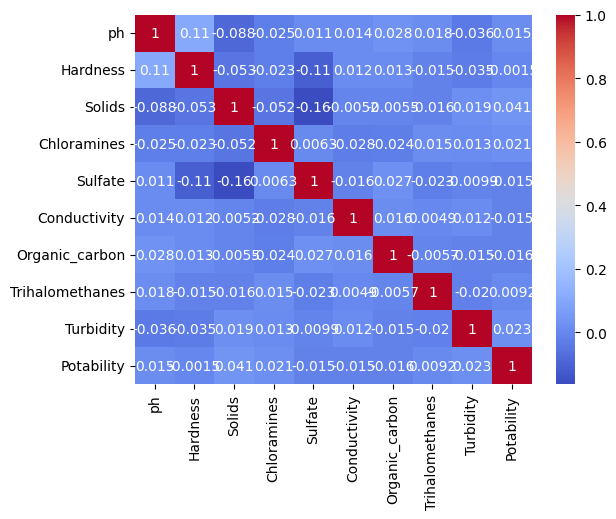

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cor,annot=True,cmap='coolwarm')
plt.show()

### Test,Train,Split

In [16]:
X=data.drop('Potability',axis=1)
Y=data['Potability']

### DATA NORMALIZATION AND STANDARDIZATION

In [17]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

normalizer=MinMaxScaler()
standardizer=StandardScaler()
X= normalizer.fit_transform(X)
X=standardizer.fit_transform(X)

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=62)

### Model Building

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# create instances of all models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Extra Trees': ExtraTreeClassifier(),
}


for name, md in models.items():
    md.fit(X_train,Y_train)
    ypred = md.predict(X_test)
    
    print(f"{name}  with accuracy : {accuracy_score(Y_test,ypred)}")

Logistic Regression  with accuracy : 0.6178660049627791
Naive Bayes  with accuracy : 0.6327543424317618
Support Vector Machine  with accuracy : 0.7245657568238213
K-Nearest Neighbors  with accuracy : 0.6550868486352357
Decision Tree  with accuracy : 0.6104218362282878
Random Forest  with accuracy : 0.7096774193548387
Bagging  with accuracy : 0.6650124069478908
AdaBoost  with accuracy : 0.6004962779156328
Gradient Boosting  with accuracy : 0.6898263027295285
Extra Trees  with accuracy : 0.5806451612903226
